In [2]:
"""
This script serves as an example of how spindles are classified using filer based and thresholding approachs
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from scipy.stats import hmean,trim_mean
import mne
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline


# define functions used in this pipeline
def window_rms(a, window_size):
    """
    a: numpy array of sample data
    window_size: size of convolution kernel
    """
    a2 = np.power(a,2)# sqaure all data points
    window = signal.gaussian(window_size,(window_size/.68)/2)# apply gaussian window with length of window_size samples
    return np.sqrt(np.convolve(a2, window, 'same')/len(a2)) * 1e2 # convolve along entire data and return root mean sqaures with the same length of the sample data
def trimmed_std(data,percentile):
    temp=data.copy()
    temp.sort()
    percentile = percentile / 2
    low = int(percentile * len(temp))
    high = int((1. - percentile) * len(temp))
    return temp[low:high].std(ddof=0)
def stage_check(x):
    import re
    if re.compile('2',re.IGNORECASE).search(x):
        return True
    else:
        return False
def intervalCheck(a,b,tol=0):#a is an array and b is a point
    return a[0]-tol <= b <= a[1]+tol
def spindle_comparison(time_interval,spindle,spindle_duration,spindle_duration_fix=True):
    """
    Compare a spindle sample with the 2nd stage sleep intervals
    """
    if spindle_duration_fix:
        spindle_start = spindle - 0.5
        spindle_end   = spindle + 1.5
        a =  np.logical_or((intervalCheck(time_interval,spindle_start)),
                           (intervalCheck(time_interval,spindle_end)))
        return a
    else:
        spindle_start = spindle - spindle_duration/2.
        spindle_end   = spindle + spindle_duration/2.
        a = np.logical_or((intervalCheck(time_interval,spindle_start)),
                           (intervalCheck(time_interval,spindle_end)))
        return a
def discritized_onset_label_auto(raw,df,spindle_segment,front=300,back=100):
    """
    Discritizing continoues time float to 0 or 1 segments with 3 seconds long
    """
    spindle_duration = df['Duration'].values
    discritized_continuous_time = np.arange(front,raw.times[-1]-back,step=spindle_segment)
    discritized_time_intervals = np.vstack((discritized_continuous_time[:-1],discritized_continuous_time[1:]))
    discritized_time_intervals = np.array(discritized_time_intervals).T
    discritized_time_to_zero_one_labels = np.zeros(len(discritized_time_intervals))
    for jj,(time_interval_1,time_interval_2) in enumerate(discritized_time_intervals):
        time_interval = [time_interval_1,time_interval_2]
        for kk,spindle in enumerate(df['Onset']):
            if spindle_comparison(time_interval,spindle,spindle_duration[kk],spindle_duration_fix=False):
                discritized_time_to_zero_one_labels[jj] = 1
    return discritized_time_to_zero_one_labels,discritized_time_intervals
def get_Onest_Amplitude_Duration_of_spindles(raw,channelList,
                                        annotations=None,
                                        moving_window_size=200,
                                        lower_threshold=.9,
                                        syn_channels=3,
                                        l_bound=0.5,h_bound=2,
                                        tol=1,higher_threshold=3.5,
                                        front=300,back=100,
                                        sleep_stage=True,
                                        proba=True,
                                        validation_windowsize=3,
                                        l_freq=11,h_freq=16):
    """
    raw: data after preprocessing
    channelList: channel list of interest, and in this study we use       'F3','F4','C3','C4','O1','O2'
    annotations: pandas DataFrame object containing manual annotations, such as sleep stages, spindle locations.
    moving_window_size: size of the moving window for convolved root mean square computation. It should work better when it is the sampling frequency, which, in this case is 500 (we downsample subjects with 1000 Hz sampling rate). 
    lower_threshold: highpass threshold for spindle detection: decision making = trimmed_mean + lower_T * trimmed_std
    higher_threshold: lowpass threshold for spindle detection: decision making = trimmed_mean + higher_T * trimmed_std
    syn_channels: criteria for selecting spindles: at least # of channels have spindle instance and also in the mean channel
    l_bound: low boundary for duration of a spindle instance
    h_bound: high boundary for duration of a spindle instance
    tol : tolerance for determing spindles (criteria in time)
    front : First few seconds of recordings that we are not interested because there might be artifacts, or it is confirmed subjects could not fall asleep within such a short period
    back : last few seconds of recordings that we are not interested due to the recording procedures
    """
    # process the data without any other information
    time=np.linspace(0,raw.last_samp/raw.info['sfreq'],raw._data[0,:].shape[0])
    RMS = np.zeros((len(channelList),raw._data[0,:].shape[0]))
    peak_time={} #preallocate
    sfreq=raw.info['sfreq']
    mph,mpl = {},{}

    for ii, names in enumerate(channelList):

        peak_time[names]=[]
        segment,_ = raw[ii,:]
        RMS[ii,:] = window_rms(segment[0,:],moving_window_size) 
        mph[names] = trim_mean(RMS[ii,int(front*sfreq):-int(back*sfreq)],0.05) + lower_threshold * trimmed_std(RMS[ii,:],0.05) 
        mpl[names] = trim_mean(RMS[ii,int(front*sfreq):-int(back*sfreq)],0.05) + higher_threshold * trimmed_std(RMS[ii,:],0.05)
        pass_ = RMS[ii,:] > mph[names]#should be greater than then mean not the threshold to compute duration

        up = np.where(np.diff(pass_.astype(int))>0)
        down = np.where(np.diff(pass_.astype(int))<0)
        up = up[0]
        down = down[0]
        #######key to idenfity segments that goes beyond the lower threshold########
        #print(down[0],up[0])
        if down[0] < up[0]:
            down = down[1:]
        #print(down[0],up[0])
        #############################
        if (up.shape > down.shape) or (up.shape < down.shape):
            size = np.min([up.shape,down.shape])
            up = up[:size]
            down = down[:size]
        C = np.vstack((up,down))
        for pairs in C.T:
            if l_bound < (time[pairs[1]] - time[pairs[0]]) < h_bound:
                SegmentForPeakSearching = RMS[ii,pairs[0]:pairs[1]]
                if np.max(SegmentForPeakSearching) < mpl[names]:
                    temp_temp_time = time[pairs[0]:pairs[1]]
                    ints_temp = np.argmax(SegmentForPeakSearching)
                    peak_time[names].append(temp_temp_time[ints_temp])
    peak_time['mean']=[];peak_at=[];duration=[]
    RMS_mean=hmean(RMS)
    # apply the same algorithm to the mean of the RMSs
    mph['mean'] = trim_mean(RMS_mean[int(front*sfreq):-int(back*sfreq)],0.05) + lower_threshold * trimmed_std(RMS_mean,0.05)
    mpl['mean'] = trim_mean(RMS_mean[int(front*sfreq):-int(back*sfreq)],0.05) + higher_threshold * trimmed_std(RMS_mean,0.05)
    pass_ =RMS_mean > mph['mean']
    up = np.where(np.diff(pass_.astype(int))>0)
    down= np.where(np.diff(pass_.astype(int))<0)
    up = up[0]
    down = down[0]
    ###############################
    #print(down[0],up[0])
    if down[0] < up[0]:
        down = down[1:]
    #print(down[0],up[0])
    #############################
    if (up.shape > down.shape) or (up.shape < down.shape):
        size = np.min([up.shape,down.shape])
        up = up[:size]
        down = down[:size]
    C = np.vstack((up,down))
    for pairs in C.T:
        
        if l_bound < (time[pairs[1]] - time[pairs[0]]) < h_bound:
            SegmentForPeakSearching = RMS_mean[pairs[0]:pairs[1],]
            if np.max(SegmentForPeakSearching)< mpl['mean']:
                temp_time = time[pairs[0]:pairs[1]]
                ints_temp = np.argmax(SegmentForPeakSearching)
                peak_time['mean'].append(temp_time[ints_temp])
                peak_at.append(SegmentForPeakSearching[ints_temp])
                duration_temp = time[pairs[1]] - time[pairs[0]]
                duration.append(duration_temp) 
    time_find=[];mean_peak_power=[];Duration=[];
    for item,PEAK,duration_time in zip(peak_time['mean'],peak_at,duration):
        temp_timePoint=[]
        for ii, names in enumerate(channelList):
            try:
                temp_timePoint.append(min(enumerate(peak_time[names]), key=lambda x: abs(x[1]-item))[1])
            except:
                temp_timePoint.append(item + 2)
        try:
            if np.sum((abs(np.array(temp_timePoint) - item)<tol).astype(int))>=syn_channels:
                time_find.append(float(item))
                mean_peak_power.append(PEAK)
                Duration.append(duration_time)
        except:
            pass
    ############ the end of the processing in which no other inputs ##
    #### update the spindles we found if we want to add information of sleep stages ######
    if sleep_stage:
        
        temp_time_find=[];temp_mean_peak_power=[];temp_duration=[];
        # seperate out stage 2
        stages = annotations[annotations.Annotation.apply(stage_check)]
        On = stages[::2];Off = stages[1::2]
        stage_on_off = list(zip(On.Onset.values, Off.Onset.values))
        if abs(np.diff(stage_on_off[0]) - 30) < 2:
            pass
        else:
            On = stages[1::2];Off = stages[::2]
            stage_on_off = list(zip(On.Onset.values[1:], Off.Onset.values[2:]))
        for single_time_find, single_mean_peak_power, single_duration in zip(time_find,mean_peak_power,Duration):
            for on_time,off_time in stage_on_off:
                if intervalCheck([on_time,off_time],single_time_find,tol=tol):
                    temp_time_find.append(single_time_find)
                    temp_mean_peak_power.append(single_mean_peak_power)
                    temp_duration.append(single_duration)
        time_find=temp_time_find;mean_peak_power=temp_mean_peak_power;Duration=temp_duration
    
    ####### decision function based on spindles we have just found ####
    """
    A single floating representation is computed based on the validation window size (say 3 seconds), and information like peak power densities and peak frequencies are added to the feature space.
    We fit the standandardized features with the labels (spindles found by the automated pipeline)
    A prediction probability is computed using scikit-learn::logisticregression
    """
    decision_features=None;auto_proba=None;auto_label=None
    if proba:
        result = pd.DataFrame({'Onset':time_find,'Duration':Duration,'Annotation':['spindle']*len(Duration)})     
        auto_label,_ = discritized_onset_label_auto(raw,result,validation_windowsize)
        events = mne.make_fixed_length_events(raw,id=1,start=front,stop=raw.times[-1]-back,duration=validation_windowsize)
        epochs = mne.Epochs(raw,events,event_id=1,tmin=0,tmax=validation_windowsize,preload=True)
        data = epochs.get_data()[:,:,:-1]
        full_prop=[]        
        for d in data:    
            temp_p=[]
            #fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(8,8))
            for ii,(name) in enumerate(zip(channelList)):#,ax.flatten())):
                rms = window_rms(d[ii,:],500)
                l = trim_mean(rms,0.05) + lower_threshold * trimmed_std(rms,0.05)
                h = trim_mean(rms,0.05) + higher_threshold * trimmed_std(rms,0.05)
                prop = (sum(rms>l)+sum(rms<h))/(sum(rms<h) - sum(rms<l))
                if np.isinf(prop):
                    prop = (sum(rms>l)+sum(rms<h))
                temp_p.append(prop)
                
            
            full_prop.append(temp_p)
        psds,freq = mne.time_frequency.psd_multitaper(epochs,fmin=l_freq,fmax=h_freq,tmin=0,tmax=3,low_bias=True,)
        psds = 10* np.log10(psds)
        features = pd.DataFrame(np.concatenate((np.array(full_prop),psds.max(2),freq[np.argmax(psds,2)]),1))
        decision_features = StandardScaler().fit_transform(features.values,auto_label)
        clf = LogisticRegressionCV(Cs=np.logspace(-4,6,11),cv=5,tol=1e-7,max_iter=int(1e7))
        clf.fit(decision_features,auto_label)
        auto_proba=clf.predict_proba(decision_features)[:,-1]
    return time_find,mean_peak_power,Duration,mph,mpl,auto_proba,auto_label


file_to_read = "suj28_l2nap_day1.fif"
raw=mne.io.read_raw_fif(file_to_read,add_eeg_ref=False,preload=True)#loading the preprocessed data
raw.resample(500)
raw.filter(11,16)
channelList = ['F3','F4','C3','C4','O1','O2']
annotation = pd.read_csv('suj28_nap_day1_edited_annotations.txt')
time_find,mean_peak_power,Duration,mph,mpl,auto_proba,auto_label=get_Onest_Amplitude_Duration_of_spindles(raw,
                                                                        channelList,
                                                                        moving_window_size=500,
                                                                        annotations=annotation,
                                                                        lower_threshold=.4,
                                                                        higher_threshold=3.4,
                                                                        syn_channels=3,
                                                                        l_bound=0.5,
                                                                        h_bound=2,
                                                                        sleep_stage=True,
                                                                        proba=True,
                                                                        tol=1)

result = pd.DataFrame({"Onset":time_find,"Amplitude":mean_peak_power,'Duration':Duration})
result['Annotation'] = 'auto spindle'

#result.to_csv('spindle_detection_suj28.txt',index_label=False)

Opening raw data file C:\Users\Sammauel\Documents\csc59969\EEG\EEG-Visualization\Inspection\suj28_l2nap_day1.fif...
This filename (C:\Users\Sammauel\Documents\csc59969\EEG\EEG-Visualization\Inspection\suj28_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 1807649 =      0.000 ...  1807.649 secs
Ready.
Reading 0 ... 1807649  =      0.000 ...  1807.649 secs...


<ipython-input-2-2f49bcdb33cf>:242: RuntimeWarning: This filename (C:\Users\Sammauel\Documents\csc59969\EEG\EEG-Visualization\Inspection\suj28_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw=mne.io.read_raw_fif(file_to_read,add_eeg_ref=False,preload=True)#loading the preprocessed data


Band-pass filtering from 11 - 16 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-2-2f49bcdb33cf>:244: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw.filter(11,16)


469 matching events found
Applying baseline correction (mode: mean)
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 469 events and 1501 original time points ...


<ipython-input-2-2f49bcdb33cf>:214: DeprecationWarning: add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
  epochs = mne.Epochs(raw,events,event_id=1,tmin=0,tmax=validation_windowsize,preload=True)


0 bad epochs dropped


In [2]:
result.head()

,Amplitude,Duration,Onset,Annotation
0,7.905970,1.102,695.810,auto spindle
1,6.556632,0.804,707.352,auto spindle
2,6.698177,0.590,714.432,auto spindle
3,6.947769,0.862,717.776,auto spindle
4,10.665980,1.330,729.534,auto spindle


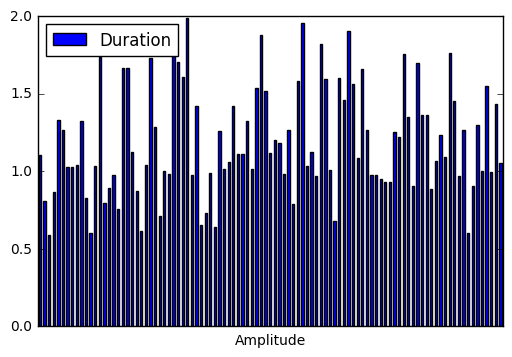

In [4]:
result.plot.bar(x='Amplitude', y='Duration')
plt.xticks([])
plt.show()

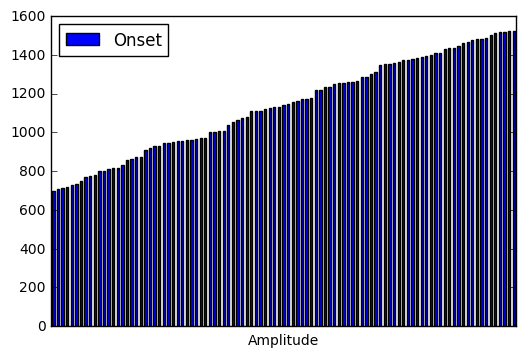

In [29]:
result.plot.bar(x='Amplitude', y='Onset')
plt.xticks([])
plt.show()

In [ ]:
result.plot.line()